In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, ShuffleSplit
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
np.random.seed(15)  # for reproducibility

### Load and clean data

In [33]:
df = pd.read_csv('data/mpg.csv')
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8.0,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8.0,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8.0,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8.0,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8.0,302.0,140,3449,10.5,70,1,ford torino


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
mpg             398 non-null float64
cylinders       396 non-null float64
displacement    398 non-null float64
horsepower      398 non-null object
weight          398 non-null int64
acceleration    398 non-null float64
model_year      398 non-null int64
origin          398 non-null int64
name            398 non-null object
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


In [35]:
# horsepower coded as an object. typically means some weird values ('?')
df.loc[df['horsepower']== '?', 'horsepower'] = None
df['horsepower'] = df['horsepower'].apply(pd.to_numeric)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
mpg             398 non-null float64
cylinders       396 non-null float64
displacement    398 non-null float64
horsepower      392 non-null float64
weight          398 non-null int64
acceleration    398 non-null float64
model_year      398 non-null int64
origin          398 non-null int64
name            398 non-null object
dtypes: float64(5), int64(3), object(1)
memory usage: 28.1+ KB


In [36]:
# check which columns have missing values
df.columns[df.isnull().any()].tolist()

['cylinders', 'horsepower']

In [37]:
# look at rows with missing values
df.loc[df['cylinders'].isnull()]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
6,14.0,NaN,454.0,220.0,4354,9.0,70,1,chevrolet impala
23,26.0,NaN,121.0,113.0,2234,12.5,70,2,bmw 2002


In [38]:
# fill with value (mean, median, mode, etc.)
df['cylinders'].fillna(df['cylinders'].median(), inplace=True)
df['horsepower'].fillna(df['horsepower'].mean(), inplace=True)

# KNN or regression imputation

### Distribution of target variable

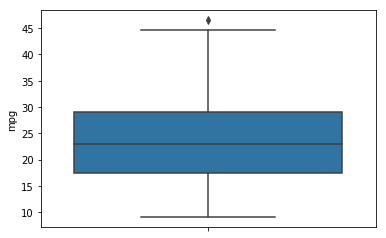

In [39]:
sns.boxplot(y=df['mpg']);

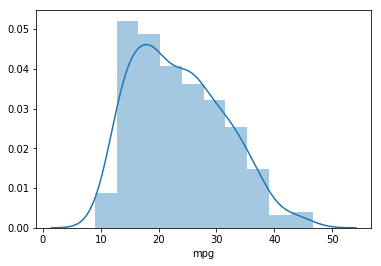

In [40]:
sns.distplot(df['mpg'], bins= 10);

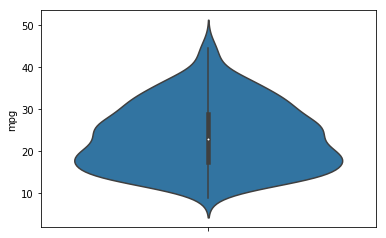

In [41]:
sns.violinplot(y=df['mpg']);

### EDA

In [42]:
df.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.444724,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.697742,104.269838,38.199187,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,76.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,95.000000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,125.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


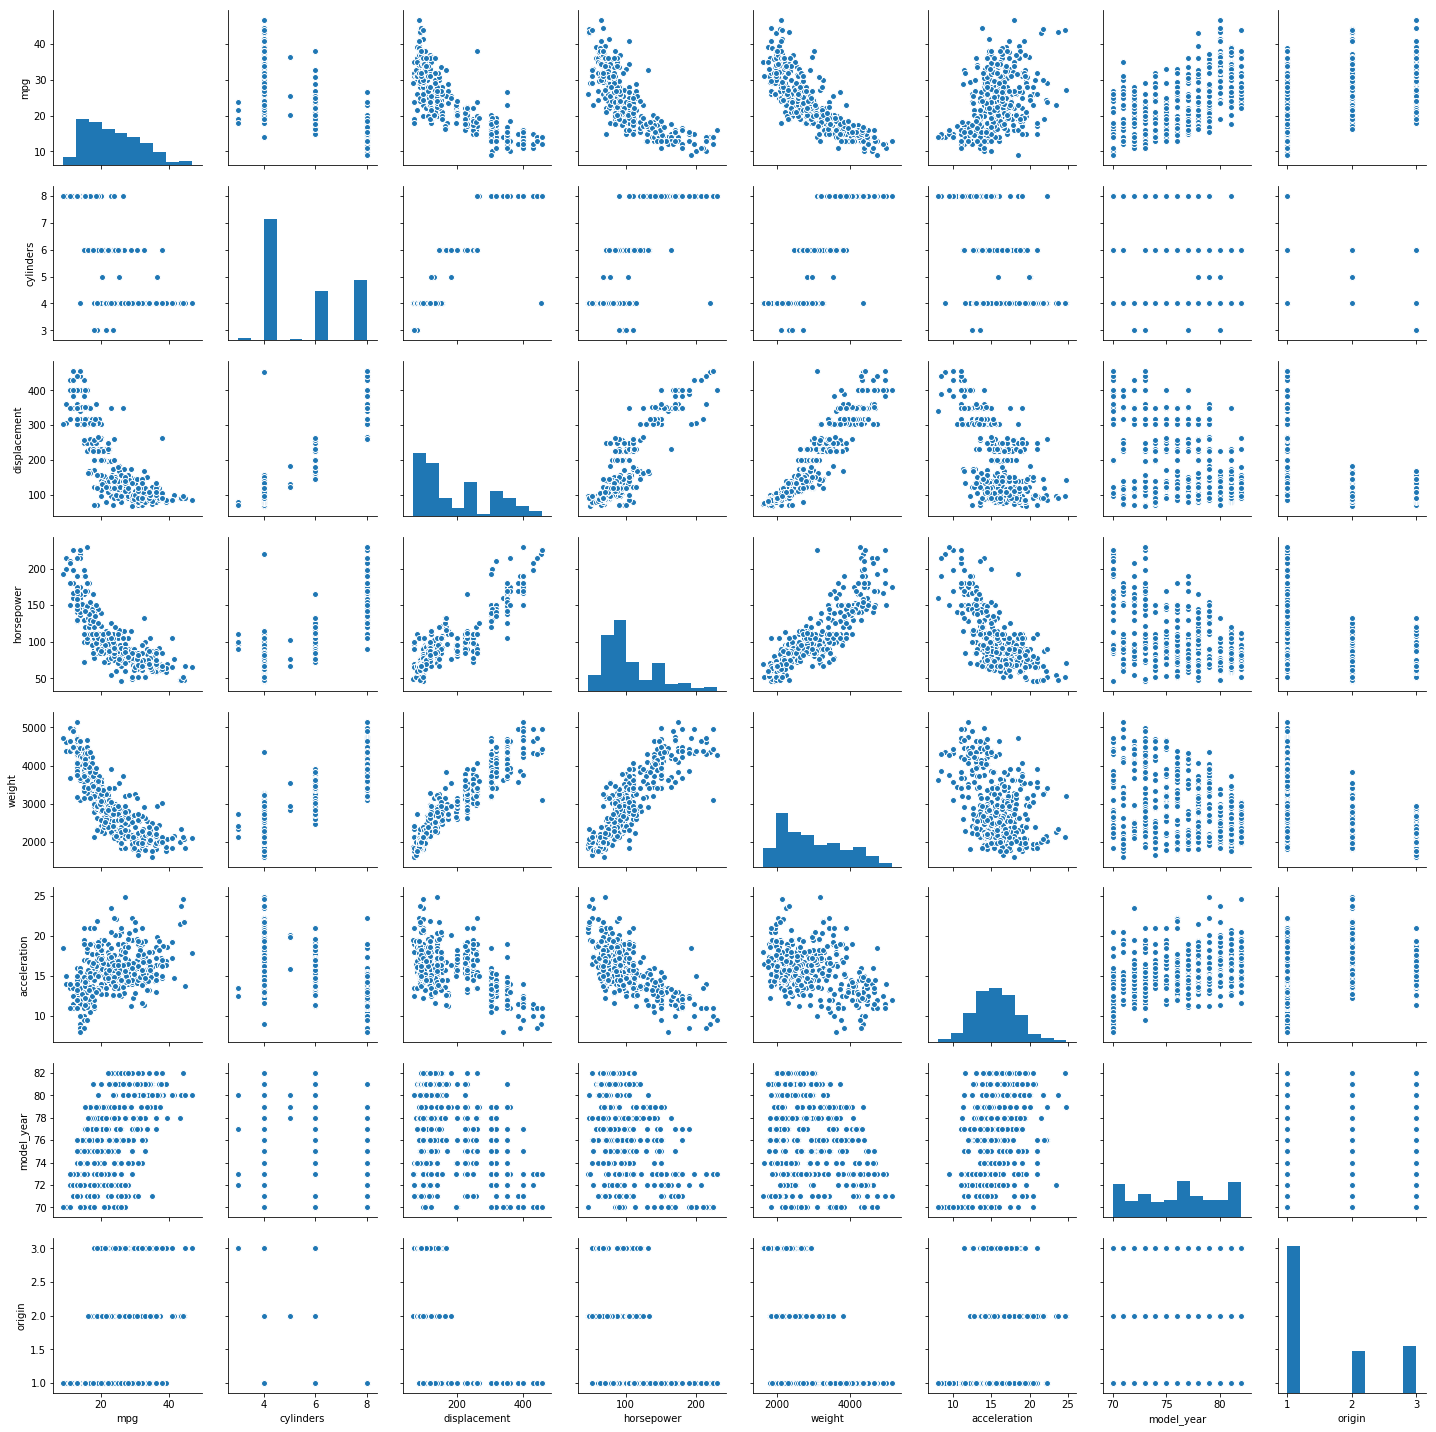

In [43]:
sns.pairplot(df);

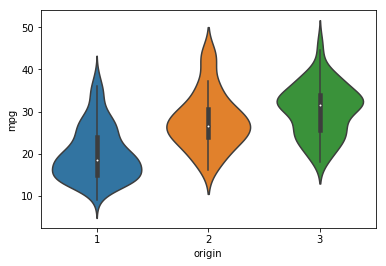

In [44]:
sns.violinplot(x=df['origin'], y=df['mpg']);

In [45]:
corr = df.corr()
corr

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
mpg,1.000000,-0.769662,-0.804203,-0.771437,-0.831741,0.420289,0.579267,0.563450
cylinders,-0.769662,1.000000,0.937717,0.822602,0.888042,-0.492256,-0.339770,-0.559386
displacement,-0.804203,0.937717,1.000000,0.893646,0.932824,-0.543684,-0.370164,-0.609409
horsepower,-0.771437,0.822602,0.893646,1.000000,0.860574,-0.684259,-0.411651,-0.453669
weight,-0.831741,0.888042,0.932824,0.860574,1.000000,-0.417457,-0.306564,-0.581024
acceleration,0.420289,-0.492256,-0.543684,-0.684259,-0.417457,1.000000,0.288137,0.205873
model_year,0.579267,-0.339770,-0.370164,-0.411651,-0.306564,0.288137,1.000000,0.180662
origin,0.563450,-0.559386,-0.609409,-0.453669,-0.581024,0.205873,0.180662,1.000000


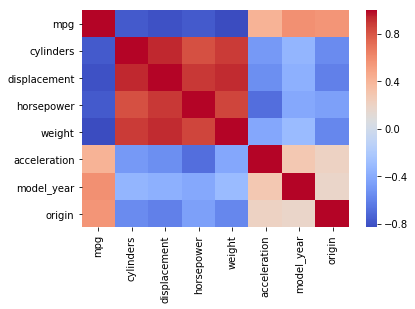

In [46]:
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='coolwarm');

### Observations from EDA

1. Target variable fairly normally distributed. Verify residuals are also normally distributed, after fitting model.
2. Some correlations (i.e. weight, horespower) look to be non-linearly correlated with target (mpg). Transformations (feature engineering) likely beneficial.
3. Lots of multicollinearity (cylinders, displacement, horsepower, weight). Regularization will be necessary. 
4. 'Origin' variable is categorical.

### Feature Engineering

In [47]:
# Origin (1, 2, 3) to categorical via dummy variables.
origin_dummies = pd.get_dummies(df['origin'], prefix='origin')
origin_dummies.head(3)

,origin_1,origin_2,origin_3
0,1,0,0
1,1,0,0
2,1,0,0


In [48]:
df = pd.concat([df, origin_dummies.iloc[:, 1:]], axis=1)
df.head(3)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name,origin_2,origin_3
0,18.0,8.0,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu,0,0
1,15.0,8.0,350.0,165.0,3693,11.5,70,1,buick skylark 320,0,0
2,18.0,8.0,318.0,150.0,3436,11.0,70,1,plymouth satellite,0,0


In [51]:
features = ['cylinders', 'displacement', 'horsepower',
            'weight', 'acceleration', 'model_year', 
            'origin_2', 'origin_3']

y = df['mpg']
X = df[features]

### Train test split

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

### Linear model fitting

In [53]:
X_train.head(3)

,cylinders,displacement,horsepower,weight,acceleration,model_year,origin_2,origin_3
47,6.0,250.0,100.0,3282,15.0,71,0,0
273,4.0,119.0,97.0,2405,14.9,78,0,1
58,4.0,97.5,80.0,2126,17.0,72,0,0


In [54]:
def rmse_cross_val(model, folds, X_train, y_train):
    '''Implements a shuffled cross val score for RMSE'''
    kf = KFold(n_splits=folds, shuffle=True, random_state=15)  # shuffle data before creating folds
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-scores)
    print("Cross validated scores:", rmse_scores)
    print("Avg CV RMSE: %0.2f (+/- %0.2f)" % (rmse_scores.mean(), rmse_scores.std() * 2))

In [55]:
lm = LinearRegression()

rmse_cross_val(lm, 3, X_train[features], y_train)

lm.fit(X_train[features], y_train)
[(col, coef) for col, coef in zip(features, lm.coef_)]

Cross validated scores: [ 3.19995718  3.21679442  3.47502297]
Avg CV RMSE: 3.30 (+/- 0.25)


[('cylinders', -0.11499909307683764),
 ('displacement', 0.015992273087042118),
 ('horsepower', -0.0029476695867568107),
 ('weight', -0.0069619144608215958),
 ('acceleration', 0.10327577869271158),
 ('model_year', 0.7907792143576855),
 ('origin_2', 2.9063806103270116),
 ('origin_3', 2.7611756842879687)]

### Lasso

In [56]:
lasso = Lasso(alpha=0.5)

# tune with cross val
rmse_cross_val(lasso, 3, X_train[features], y_train)

# evaluate coefficients by fitting to all of data
lasso.fit(X_train[features], y_train)
[(col, coef) for col, coef in zip(features, lasso.coef_)]

Cross validated scores: [ 3.26800232  3.34284331  3.4530703 ]
Avg CV RMSE: 3.35 (+/- 0.15)


[('cylinders', 0.0),
 ('displacement', -0.0016210314768030235),
 ('horsepower', 0.0),
 ('weight', -0.0064863974340177277),
 ('acceleration', 0.0),
 ('model_year', 0.70417529156630732),
 ('origin_2', 0.0),
 ('origin_3', 0.0)]

### Ridge

In [57]:
ridge = Ridge(alpha=2)

rmse_cross_val(ridge, 3, X_train[features], y_train)

ridge.fit(X_train[features], y_train)
ridge.coef_
[(col, coef) for col, coef in zip(features, ridge.coef_)]

Cross validated scores: [ 3.20103665  3.23370639  3.44479444]
Avg CV RMSE: 3.29 (+/- 0.22)


[('cylinders', -0.097019834865214469),
 ('displacement', 0.01432679397243878),
 ('horsepower', -0.0017921308055210703),
 ('weight', -0.0069496481473515382),
 ('acceleration', 0.099534817610796536),
 ('model_year', 0.78704433619264758),
 ('origin_2', 2.6375398113099005),
 ('origin_3', 2.4954696085725523)]

### Random Forest

In [58]:
rf = RandomForestRegressor()

rmse_cross_val(rf, 3, X_train[features], y_train)

rf.fit(X_train[features], y_train)
[(col, feat_importance) for col, feat_importance in zip(features, rf.feature_importances_)]

Cross validated scores: [ 2.53389345  3.19074768  2.71439802]
Avg CV RMSE: 2.81 (+/- 0.55)


[('cylinders', 0.001471279812221248),
 ('displacement', 0.53799738898769611),
 ('horsepower', 0.081819883359694867),
 ('weight', 0.20806991251926985),
 ('acceleration', 0.026171884971587574),
 ('model_year', 0.1390077429876154),
 ('origin_2', 0.0032523012904592716),
 ('origin_3', 0.0022096060714555466)]

From Lasso coefficients and Random Forest feature importances these varibles look to be worth further investgation:
1. displacement
2. weight
3. model year
4. horsepower

In [27]:
df[['mpg', 'displacement', 'weight', 'model_year', 'horsepower']].corr()

,mpg,displacement,weight,model_year,horsepower
mpg,1.000000,-0.804203,-0.831741,0.579267,-0.771437
displacement,-0.804203,1.000000,0.932824,-0.370164,0.893646
weight,-0.831741,0.932824,1.000000,-0.306564,0.860574
model_year,0.579267,-0.370164,-0.306564,1.000000,-0.411651
horsepower,-0.771437,0.893646,0.860574,-0.411651,1.000000


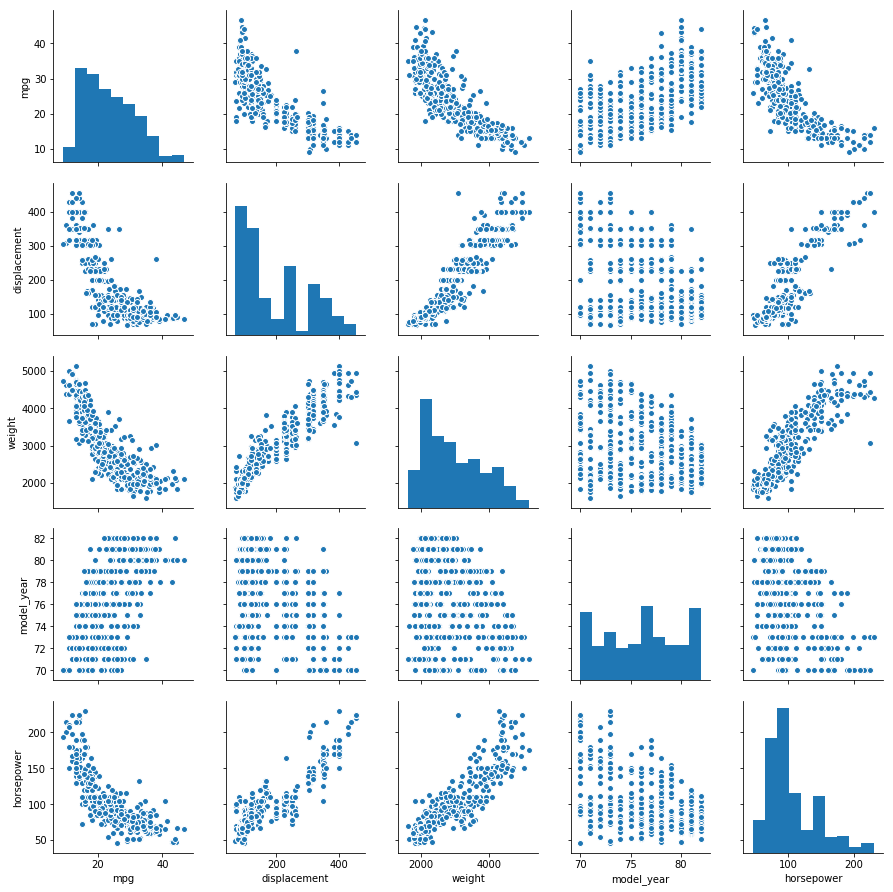

In [30]:
sns.pairplot(df[['mpg', 'displacement', 'weight', 'model_year', 'horsepower']]);